In [ ]:
try:
    from gekko import GEKKO
except:
    !pip install gekko
    # restart kernel if this doesn't import
    from gekko import GEKKO

In [ ]:
# from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
 
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from pickle import dump, load

In [ ]:
#%% Mount Google drive if you use colab for save and load LSTM models
if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  from google.colab import drive
  drive.mount('/content/drive')
    
else:
  print('Not running on Colab')

Running on Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Create *MIMO* FOPDT Gekko model

In [ ]:
tf = 60 # fianl time
P = 20 # Prediction Horizon
m=GEKKO(remote=True)
m.time = np.linspace(0,P-1,P)

# Process Gain
K11 = m.FV(2)
K12 = m.FV(.5) 
K21 = m.FV(.5) 
K22 = m.FV(2)

# Time Constant
tau11 = m.FV(5)
tau12 = m.FV(5) 
tau21 = m.FV(5) 
tau22 = m.FV(5) 

# # Input Scenario for open-loop
# u1_input = np.zeros(tf)
# u1_input[5:] = 1
# u2_input = np.zeros(tf)
# u2_input[15:] = -1

# Setpoint Scenario for closed-loop
SP1 = np.zeros(tf)
SP2 = -np.zeros(tf)

SP1[0:] = 0.5
SP2[0:] = 0.2
SP1[20:] = 0.3
SP2[40:] = 0.8

# Gekko variables for Input Output
y1 = m.CV(0)
y2 = m.CV(0)
u1 = m.MV(0, lb=0, ub=5)
u2 = m.MV(0, lb=0, ub=5)

y1.STATUS = 1
y2.STATUS = 1

u1.STATUS = 1
u2.STATUS = 1

u1.FSTATUS = 0
u2.FSTATUS = 0

u1.DCOST = 1e5
u2.DCOST = 1e5
y1.WSP = 1e6
y2.WSP = 1e6

#FOPDT Equation
m.Equation(y1.dt()+y1 == K11/tau11*u1 + K21/tau21*u2) 
m.Equation(y2.dt()+y2 == K12/tau12*u1 + K22/tau22*u2) 

m.options.CV_TYPE = 2
m.options.IMODE = 6

u1_store = np.ones(tf)*u1.VALUE
u2_store = np.ones(tf)*u2.VALUE
y1_store = np.ones(tf)*y1.VALUE
y2_store = np.ones(tf)*y2.VALUE

for i in range(tf):
  y1.SP = SP1[i]
  y2.SP = SP2[i]
  
  m.solve(disp=False)
  
  u1_store[i] = u1.NEWVAL
  u2_store[i] = u2.NEWVAL
  y1_store[i] = y1.value[1]
  y2_store[i] = y2.value[1]

plt.figure(0)
plt.subplot(2,1,1)
plt.plot(SP1, drawstyle='steps')
plt.plot(SP2, drawstyle='steps')
plt.plot(y1_store)
plt.plot(y2_store)
plt.legend(['SP1', 'SP2', 'y1', 'y2'])

plt.subplot(2,1,2)
plt.plot(u1_store, drawstyle='steps')
plt.plot(u2_store, drawstyle='steps')
plt.legend(['u1', 'u2'])
plt.show()

## 2. Generating Setpoint Sequence (Full Random or Latin Hypercube Sampling)

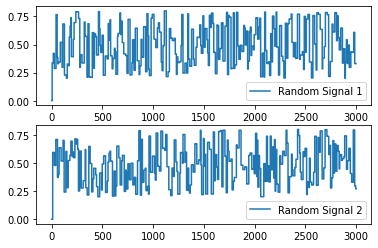

In [ ]:
nstep = 3000 # Choose length of training data 

# random signal generation

nVar = 2 # number of Variables that need random signal
random_signal = np.zeros((nVar,nstep))
for j in range(nVar):
  a_range = [0.2,0.8]
  a = np.random.rand(nstep) * (a_range[1]-a_range[0]) + a_range[0] # range for amplitude
  a[0] = 0

  b_range = [5, 20]
  b = np.random.rand(nstep) *(b_range[1]-b_range[0]) + b_range[0] # range for frequency
  b = np.round(b)
  b = b.astype(int)

  b[0] = 0

  for i in range(1,np.size(b)):
      b[i] = b[i-1]+b[i]

  # Random Signal
  i=0
  while b[i]<np.size(random_signal[j]):
      k = b[i]
      random_signal[j,k:] = a[i]
      i=i+1

plt.figure(0) 
plt.subplot(2,1,1)
plt.plot(random_signal[0], drawstyle='steps',label='Random Signal 1')
plt.legend()
plt.subplot(2,1,2)
plt.plot(random_signal[1], drawstyle='steps',label='Random Signal 2')
plt.legend()
plt.show()

## 3. Evaluating the Random Setpoints

In [ ]:
SP1 = random_signal[0]
SP2 = random_signal[1]

u1_store = np.ones(nstep)*u1.VALUE[0]
u2_store = np.ones(nstep)*u2.VALUE[0]
y1_store = np.ones(nstep)*y1.VALUE[0]
y2_store = np.ones(nstep)*y2.VALUE[0]

for i in range(nstep):
  y1.SP = SP1[i]
  y2.SP = SP2[i]
  
  m.solve(disp=False)
  
  u1_store[i] = u1.NEWVAL
  u2_store[i] = u2.NEWVAL
  y1_store[i] = y1.value[1]
  y2_store[i] = y2.value[1]


file = open(file='/content/drive/MyDrive/LSTM_MPC/FOPDT/closed_loop_data_1200.pkl',mode='wb')
dump([u1_store, u2_store, y1_store, y2_store, SP1, SP2], file)
file.close()

fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
fig.add_trace(go.Scatter(y=SP1,name="SP1"), row=1, col=1)
fig.add_trace(go.Scatter(y=SP2,name="SP2"), row=1, col=1)
fig.add_trace(go.Scatter(y=y1_store,name="y1"), row=1, col=1)
fig.add_trace(go.Scatter(y=y2_store,name="y2"), row=1, col=1)
fig.add_trace(go.Scatter(y=u1_store,name="u1"), row=2, col=1)
fig.add_trace(go.Scatter(y=u2_store,name="u2"), row=2, col=1)

fig.update_layout(
    template="plotly_white",
    font_family="Times New Roman",
    font_size = 20
    )

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True, row=1 , col=1)
fig.update_xaxes(title_text='Time',showline=True, linewidth=2, linecolor='black', mirror=True, row=2, col=1)
fig.update_yaxes(title_text='y', showline=True, linewidth=2, linecolor='black', mirror=True, row=1, col=1)
fig.update_yaxes(title_text='u', showline=True, linewidth=2, linecolor='black', mirror=True, row=2, col=1)
fig.show()

fig.write_image("fig1.eps")

# plt.figure(0)
# plt.subplot(2,1,1)
# plt.plot(SP1, drawstyle='steps')
# plt.plot(SP2, drawstyle='steps')
# plt.plot(y1_store)
# plt.plot(y2_store)
# plt.legend(['SP1', 'SP2', 'y1', 'y2'])

# plt.subplot(2,1,2)
# plt.plot(u1_store, drawstyle='steps')
# plt.plot(u2_store, drawstyle='steps')
# plt.legend(['u1', 'u2'])
# plt.show()